In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [3]:
pd.__version__

'0.16.2'

In [4]:
sns.__version__

'0.6.0'

Apache log analysis with Pandas
=========

    Nikolay Koldunov
    koldunovn@gmail.com
[koldunov.net](http://koldunov.net)

In this notebook, I am going to show simple example of an Apache access log analysis with pandas. It's my first experience with pandas, and I am sure there are better and more efficient ways to do some of the things shown here. So comments, suggestions and corrections of my broken English are very welcome. You can send me an email, or create a PR for [this notebook at github](https://github.com/koldunovn/nk_public_notebooks). 

### Load and parse the data

We will need [apachelog module](http://code.google.com/p/apachelog/), for parsing the log. We also have to know the format of the log that is set in the Apache config. In my case I have no access to the Apache config, but the [hoster provide description of the format](http://help.sweb.ru/entry/2484/) on his help page. Below is the format itself and a short description of every element:
    
    format = r'%V %h  %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'
    
Here (copied mostly from [this SO post](http://stackoverflow.com/questions/9234699/understanding-apache-access-log)):
    
    %V          - the server name according to the UseCanonicalName setting
    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    \"%i\"      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %T          - Apache request time  
    

In [5]:
import apachelog

Set the format:

In [6]:
fformat = r'%V %h %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'

Create the parcer:

In [7]:
p = apachelog.parser(fformat)

In [8]:
test_string = \
'koldunov.net 85.26.235.202 - - [16/Mar/2013:00:19:43 +0400] "GET /?p=364 HTTP/1.0" 200 65237 \
"http://koldunov.net/?p=364" "Mozilla/5.0 (Windows NT 5.1) \
AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11" 0'

In [9]:
data = p.parse(test_string)

In [10]:
data

{'%>s': '200',
 '%T': '0',
 '%V': 'koldunov.net',
 '%b': '65237',
 '%h': '85.26.235.202',
 '%i': 'http://koldunov.net/?p=364',
 '%l': '-',
 '%r': 'GET /?p=364 HTTP/1.0',
 '%t': '[16/Mar/2013:00:19:43 +0400]',
 '%u': '-',
 '%{User-Agent}i': 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11'}

Looks like the parser works. Now to load some real world data (sample file located [here](http://dl.dropbox.com/u/107639/notebooks/access_log_for_pandas) and [here](https://github.com/koldunovn/nk_public_notebooks/raw/master/access_log_for_pandas)):

In [11]:
log = open('access_log_for_pandas').readlines()

Parse every line of it and create a list of dictionaries:

In [12]:
log_list = []
for line in log:
    try:
        data = p.parse(line)
    except:
        sys.stderr.write("Unable to parse %s" % line)
    data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]
      
    log_list.append(data)


In [13]:
data['%t'][1:12]+' '+data['%t'][13:21]

'7/Mar/2013  0:19:30'

We had to tweak the time format a bit, since otherwise pandas will not be able to parse it.

### Create and tune Data Frame

This will create a list of dictionaries, that can be transformed in to a Data Frame:

In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_context('poster',rc = {"figure.figsize": [10,5.5]})

In [15]:
df = pd.DataFrame(log_list)

Show the first two lines of the Data Frame:

In [16]:
df[0:2]

,%>s,%T,%V,%b,%h,%i,%l,%r,%t,%u,%{User-Agent}i
0,200,0,www.oceanographers.ru,26126,109.165.31.156,-,-,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...
1,200,0,www.oceanographers.ru,10532,109.165.31.156,http://www.oceanographers.ru/index.php?option=...,-,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25,-,Mozilla/5.0 (Windows NT 6.1; rv:19.0) Gecko/20...


We are not going to use all the data, so let's delete some of the columns:

In [17]:
del df['%T']; del df['%V']; del df['%i']; del df['%l']; del df['%u']; del df['%{User-Agent}i']

In [18]:
df.head()

,%>s,%b,%h,%r,%t
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25


and rename columns to something that humans can understand:

In [19]:
df = df.rename(columns={'%>s': 'Status', '%b':'Size', 
                        '%h':'IP', '%r':'Request', '%t': 'Time'})

First five rows of resulting Data Frame:

In [20]:
df.head()

,Status,Size,IP,Request,Time
0,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...,16/Mar/2013 08:00:25
1,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,16/Mar/2013 08:00:25
2,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,16/Mar/2013 08:00:25
3,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,16/Mar/2013 08:00:25
4,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,16/Mar/2013 08:00:25


Convert Time column to datetime format and make an index out of it (*pop* will drop original *Time* column): 

In [21]:
tfor = '%d/%b/%Y %H:%M:%S'
df.index = pd.to_datetime(df.pop('Time'), format=tfor)

The *Status* variable is a string type, so we have to change it to int:

In [22]:
df.head()

,Status,Size,IP,Request
Time,,,,
2013-03-16 08:00:25,200,26126,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 08:00:25,200,10532,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 08:00:25,200,1853,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 08:00:25,200,37153,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 08:00:25,200,3978,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


In [23]:
df['Status'].dtype

dtype('O')

In [24]:
df['Status'] = df['Status'].astype('int')

Some of the rows in the *b* column contain '-' string, so we can't convert them with *astype*:

In [25]:
df['Size'].dtype

dtype('O')

In [26]:
df['Size'] = df['Size'].astype('int')

ValueError: invalid literal for long() with base 10: '-'

In [ ]:
df['Size'][93]

We can apply a custom function to this column, that will convert all dashes to NaN, and the rest to floats, additionally converting from bytes to megabytes:

In [27]:
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.
    
    return x

In [28]:
df['Size'] = df['Size'].apply(dash2nan)

In [29]:
df.head()

,Status,Size,IP,Request
Time,,,,
2013-03-16 08:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...
2013-03-16 08:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...
2013-03-16 08:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0
2013-03-16 08:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0
2013-03-16 08:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0


### Traffic analysis

Our first, simplest plot: outgoing traffic from the website:

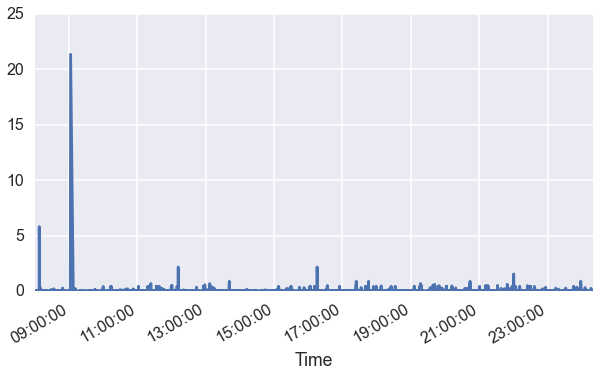

In [37]:
df['Size'].plot()

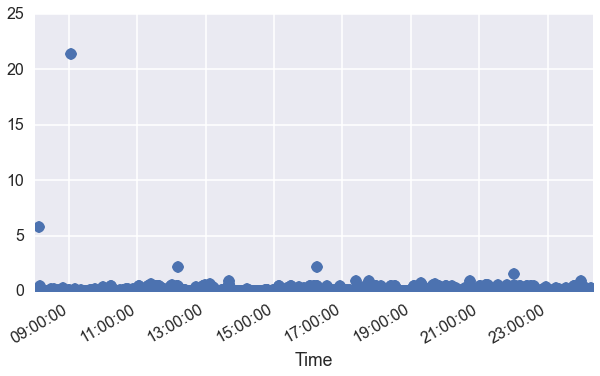

In [38]:
df['Size'].plot(style='o')

Look's like somebody downloaded something big from the website around 9 a.m.

But actually the first thing that you probably want to know is how many visits (actually hits) your site has, and how they are distributed in time. We resample the series of variable *b* with 5 minute intervals, and calculate number of requests during every time span. Actually, in this case it doesn't matter what variable we use, these numbers will indicate just how many times information from the the website was requested.

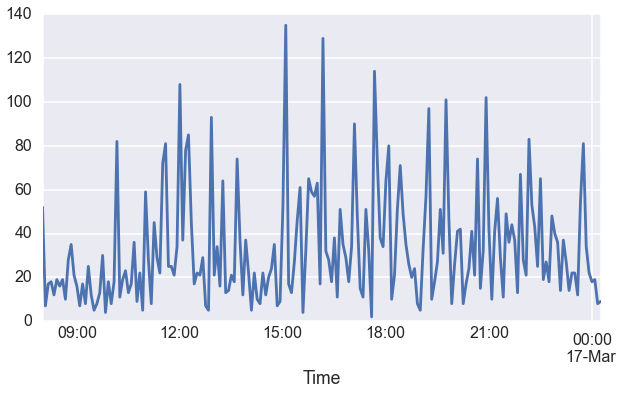

In [39]:
df_s = df['Size'].resample('5t', how='count')
df_s.plot()

We can not only count number of requests per time, but also calculate the sum of the traffic for every time span:

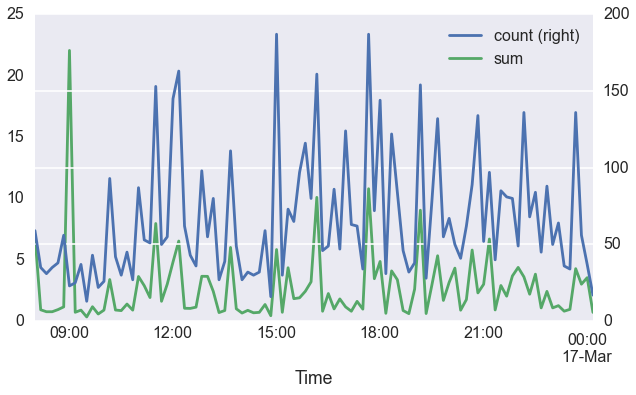

In [40]:
df_b = df['Size'].resample('10t', how=['count','sum'])
df_b.plot( secondary_y=['count'])
#legend()
#df_b['sum'].plot(secondary_y=True)
#legend()

On the plot you can see, that the number of server requests do not always coincide with the amount of traffic, and correlation is actually not extremely high:

In [41]:
df_b.corr()

,count,sum
count,1.000000,0.512629
sum,0.512629,1.000000


We can have a closer look at the curious morning peak:

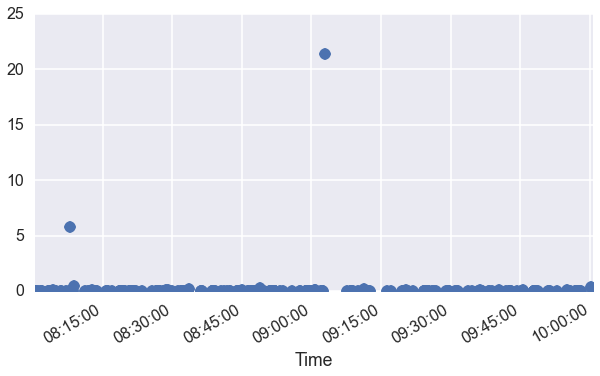

In [42]:
df['2013-03-16 8:00':'2013-03-16 10:00']['Size'].plot(style='o')

Seems that this traffic spike was caused by only one request. Let's find out how this request looks. Choose all requests with the size of the response larger than 20 Mb (remember we convert bytes to Mb):

In [43]:
df[df['Size']>20]

,Status,Size,IP,Request
Time,,,,
2013-03-16 09:02:59,200,21.365701,77.50.248.20,GET /books/Bondarenko.pdf HTTP/1.0


It was a .pdf file of a book (look at Request field), and this explains the peak in outgoing trafic at 2013-03-16 09:02:59.

Clearly 20 Mb is a large request (for our website at least :)). But what is  the typical size of the server's response? The histogram of response sizes (less than 20 Mb) looks like this:

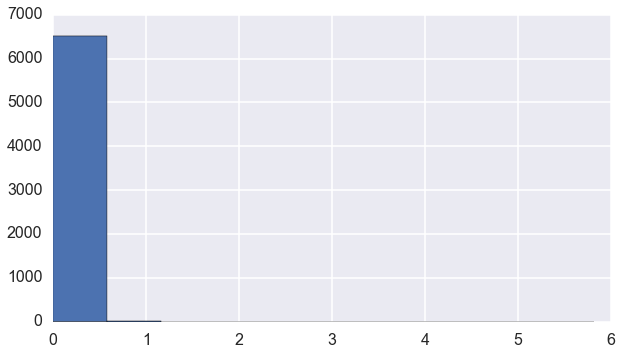

In [44]:
cc = df[df['Size']<20]
cc['Size'].hist(bins=10)

So,  most of the files are less than 0.5 Mb large. In fact they are even smaller:

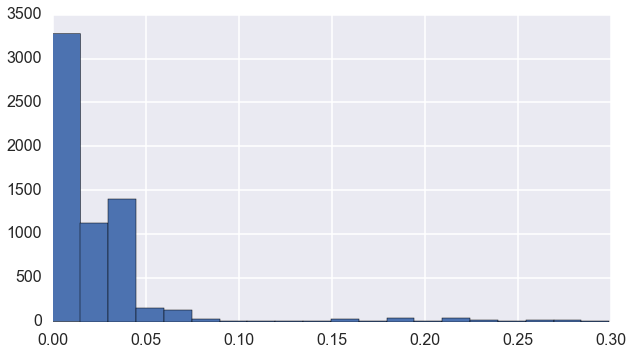

In [45]:
cc = df[df['Size']<0.3]
cc['Size'].hist(bins=20)

Very small responses can be all kinds of stuff, but larger ones are probably some relatively big files. Let's have a look at these little spikes between 0.15 and 0.25 Mb:

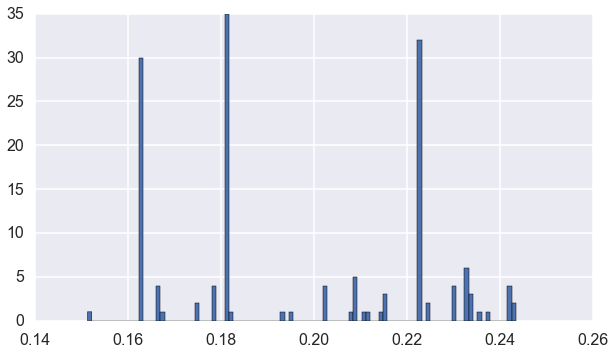

In [46]:
cc = df[(df['Size']>0.15)&(df['Size']<0.25)]
cc.Size.hist(bins=100)

We now can locate the size of the file more precisely, and find out its name:

In [47]:
cc = df[(df['Size']>0.220)&(df['Size']<0.224)]
cc.head()

,Status,Size,IP,Request
Time,,,,
2013-03-16 10:13:51,200,0.223101,178.238.18.194,GET /mypict/itpocover.png HTTP/1.0
2013-03-16 11:02:12,200,0.223101,2.95.140.217,GET /mypict/itpocover.png HTTP/1.0
2013-03-16 11:18:48,200,0.223101,213.87.138.145,GET /mypict/itpocover.png HTTP/1.0
2013-03-16 11:33:36,200,0.223101,91.207.106.252,GET /mypict/itpocover.png HTTP/1.0
2013-03-16 11:34:03,200,0.223101,212.3.137.202,GET /mypict/itpocover.png HTTP/1.0


This is one of the image files from the front page of the website. 

### Server status codes

I would like to know how different server responses are distributed through time. Let's first try a not very elegant approach. We create several variables with time series of *Status* values, each containing only a time series with one particular value. Then a Data Frame is created out of this time series. 

In [48]:
t_span = '2H'
df_404 = df['Status'][df['Status'] == 404].resample(t_span, how='count')
df_403 = df['Status'][df['Status'] == 403].resample(t_span, how='count')
df_301 = df['Status'][df['Status'] == 301].resample(t_span, how='count')
df_304 = df['Status'][df['Status'] == 304].resample(t_span, how='count')
df_200 = df['Status'][df['Status'] == 200].resample(t_span, how='count')

status_df = pd.DataFrame({'Not Found':df_404, 'Forbidden':df_403, \
                          'Moved Permanently':df_301, 'Not Modified':df_304, 'OK':df_200,})

In [49]:
status_df.head()

,Forbidden,Moved Permanently,Not Found,Not Modified,OK
Time,,,,,
2013-03-16 08:00:00,22,17,3,4,375
2013-03-16 10:00:00,26,76,2,2,607
2013-03-16 12:00:00,45,83,2,23,780
2013-03-16 14:00:00,29,34,4,2,699
2013-03-16 16:00:00,27,94,5,3,886


We plot all values at once:

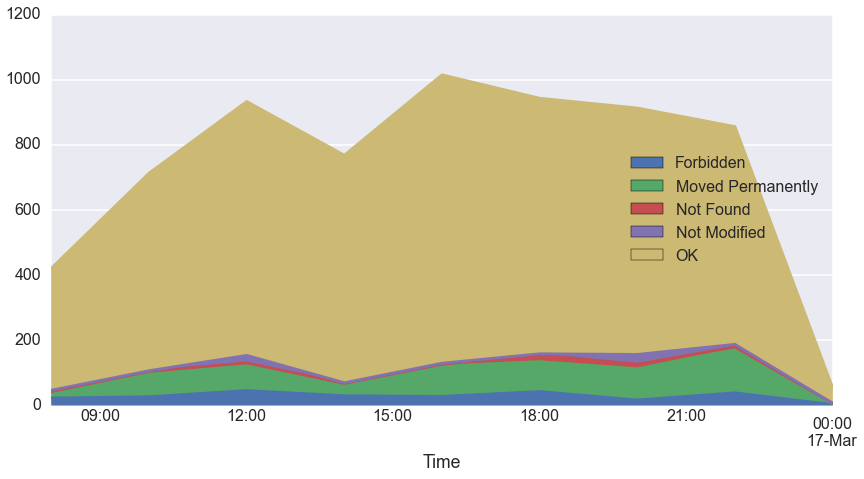

In [50]:
status_df.plot(figsize=(14, 7), kind='area')

Show only Error and Redirection status codes as a stacked plot:

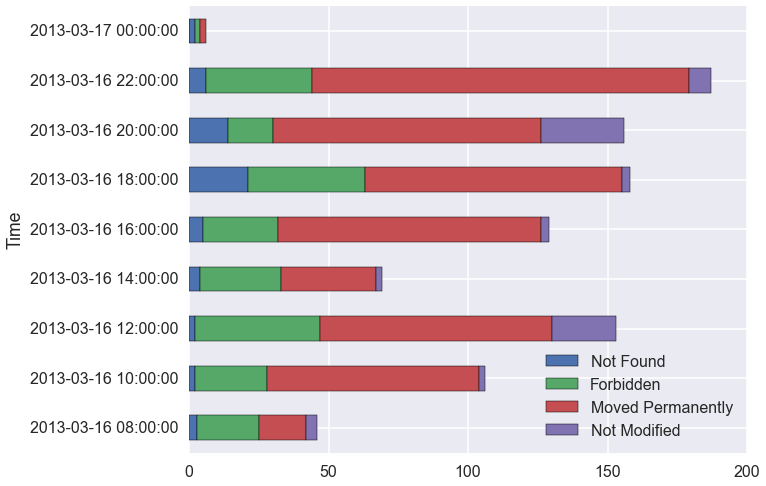

In [51]:
status_df[['Not Found','Forbidden','Moved Permanently','Not Modified']].\
                          plot(kind='barh', stacked=True, figsize=(10, 8))

### Groupby

<img src="files/splitApplyCombine.png">

But there is a better way to receive statistics about different groups of values. Here we group our data by *Status*:

In [52]:
grouped_status = df.groupby('Status')

Data are now rearranged in to several groups, each corresponding to a certain value of *Status* (here, only the first two values of every group are shown):

In [ ]:
grouped_status.groups

We can count the number of values in each group:

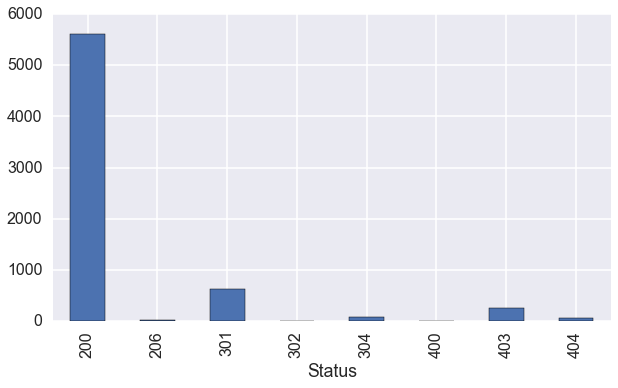

In [54]:
grouped_status.size().plot(kind='bar')

We can look at individual groups:

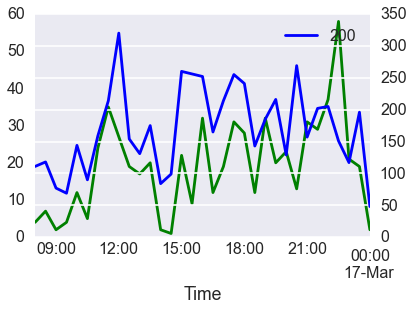

In [57]:
t_span = '30t'
grouped_status.get_group(301)['Status'].resample(t_span, how='count').plot(color='g', label='301')

grouped_status.get_group(200)['Status'].resample(t_span, how='count').plot(color='b', secondary_y=True, label='200')
plt.legend()

Or we can reproduce plot from above with less effort:

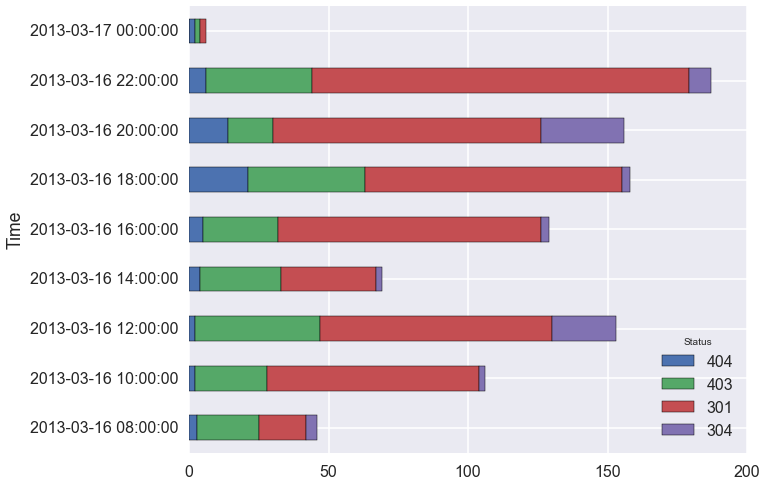

In [58]:
grouped_status['Status'].resample('2H', how='count')\
                        .swaplevel(0,1).unstack()[[404,403,301,304]].\
                        plot(kind='barh', stacked=True, figsize=(10, 8))

### IPs

Now I want to group by IPs and calculate how many requests we get from each of them: 

In [30]:
ips = df.groupby('IP').size()

In [31]:
ips.head()

IP
100.44.124.8       26
108.171.252.242    24
109.165.31.156     12
109.171.109.164     4
109.191.82.110     14
dtype: int64

I don't want to see all of them, just the top 10:

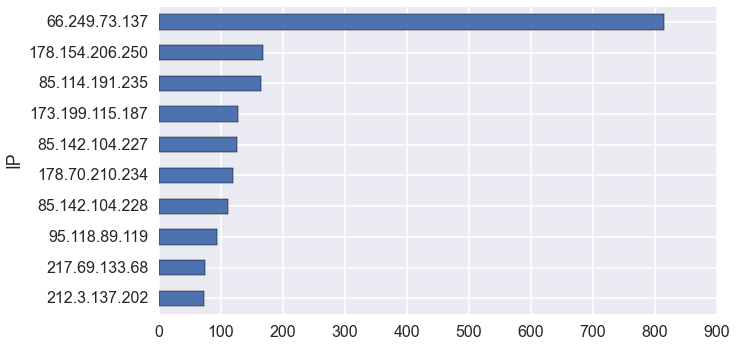

In [32]:
ips.sort()
ips[-10:].plot(kind='barh')

We also can group by both *IP* and *Status*:

In [33]:
ips_status = df.groupby(['IP', 'Status']).size()

In [34]:
ips_status.head(10)

IP               Status
100.44.124.8     200        9
                 403        6
                 404       11
108.171.252.242  200       24
109.165.31.156   200       12
109.171.109.164  200        2
                 206        2
109.191.82.110   200       12
                 404        2
109.200.149.88   200       36
dtype: int64

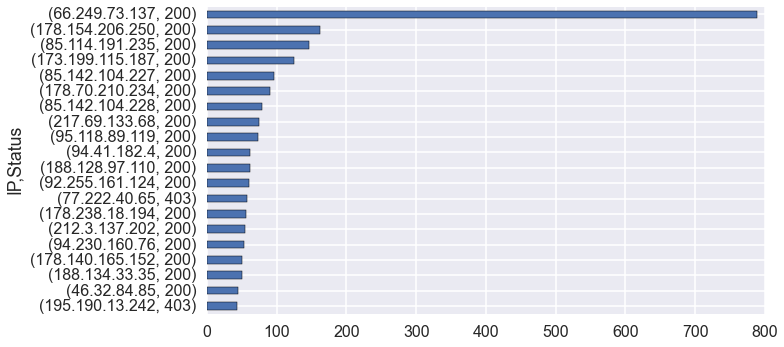

In [35]:
ips_status.sort()
ips_status[-20:].plot(kind='barh')

### Geographical information

I would like to know from which countries people or robots come to the website. It turns out that precise geolocation information is not free, but for our purposes free data bases are fine. We will use [pygeoip](https://github.com/appliedsec/pygeoip) to get information from GeoIP database, and that has to be downloaded from [here](http://dev.maxmind.com/geoip/geolite).  

Import module and initialise data base:

In [36]:
import pygeoip
gi = pygeoip.GeoIP('./GeoLiteCity.dat', pygeoip.MEMORY_CACHE)

This is how output of the pygeoip looks (we test our top IP from the previous section):

In [37]:
ipcon = gi.record_by_addr('64.233.161.99')
ipcon

{'area_code': 650,
 'city': u'Mountain View',
 'continent': 'NA',
 'country_code': 'US',
 'country_code3': 'USA',
 'country_name': 'United States',
 'dma_code': 807,
 'latitude': 37.41919999999999,
 'longitude': -122.0574,
 'metro_code': 'San Francisco, CA',
 'postal_code': u'94043',
 'region_code': u'CA',
 'time_zone': 'America/Los_Angeles'}

Guess who it is :) Looks like Google Bot is my main reader. That's rather sad :(

Loop to create a list of dictionaries with information about IP numbers. We also add information about the number of requests from each of the IPs:

In [38]:
ipcon = []
for nn, iip in enumerate(ips.index):
    rres = gi.record_by_addr(iip)
    if rres:
        #    rres['ip']                 = iip
        rres['Number'] = ips[iip]
        #delete some fields we don't need
        del rres['area_code']
        del rres['dma_code']
        del rres['metro_code']
        del rres['postal_code']
        #del rres['region_name']
        del rres['time_zone']
        del rres['country_code']
        ipcon.append(rres)
    else:
        ips = ips.drop(ips.index[[nn]])
    

Create Data Frame from this list, use ips index:

In [39]:
reg = pd.DataFrame(ipcon, index = ips.index)
reg.head()

,Number,city,continent,country_code3,country_name,latitude,longitude,region_code
IP,,,,,,,,
46.138.56.225,1,Moscow,EU,RUS,Russian Federation,55.7522,37.6156,48
188.65.69.245,1,Saint-petersburg,EU,RUS,Russian Federation,59.9167,30.2500,66
193.110.115.200,1,Kramatorsk,EU,UKR,Ukraine,48.7231,37.5563,05
194.226.214.114,1,None,EU,RUS,Russian Federation,60.0000,100.0000,None
81.200.24.83,1,Moscow,EU,RUS,Russian Federation,55.7522,37.6156,48


Group by Country:

In [40]:
country = reg.groupby('country_code3').sum()

In [41]:
country.head()

,Number,latitude,longitude
country_code3,,,
BEL,3,152.5999,13.2667
BGR,29,43.2167,27.9167
BLR,71,108.1904,58.2049
BRA,15,-43.0333,-155.5500
CHN,154,800.3276,2823.2578


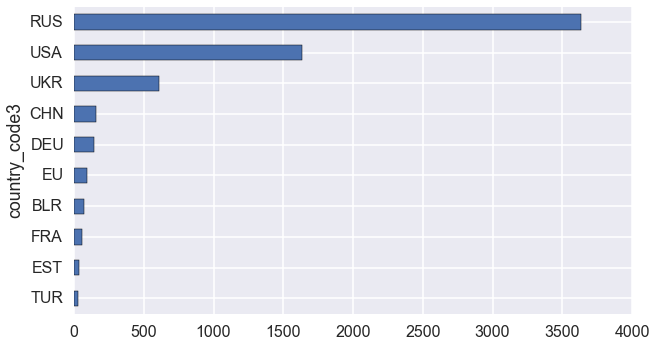

In [42]:
country = country.sort(columns=['Number'])
country.Number[-10:].plot(kind='barh')

The website is in Russian, so no surprises here.

Group by city:

In [43]:
city = reg.groupby('city').sum()

In [44]:
city.head()

,Number,latitude,longitude
city,,,
Aksaray,1,38.3725,34.0254
Artëm,1,43.3595,132.1889
Ashburn,20,78.0874,-154.9750
Astrakhan,13,46.3497,48.0408
Beijing,10,399.2890,1163.8830


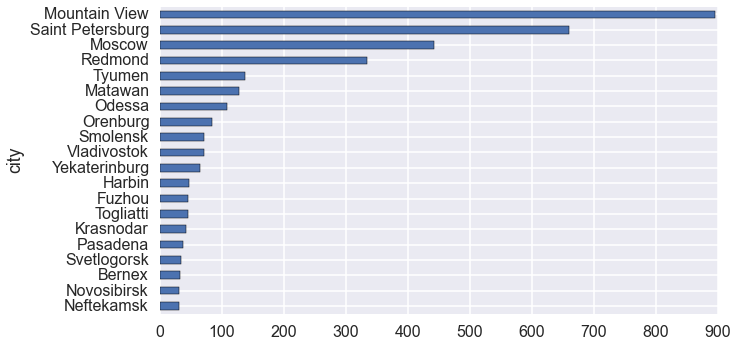

In [45]:
#ff = city.Number.agg('sum').copy()
city =city.sort(columns='Number')
city.Number[-20:].plot(kind='barh')

The first 3 are kind of expected, but Tyumen, a Russian city located in the middle of Eurasia thousands of kilometers away from the nearest ocean coast, is a bit of a surprise (the website is about Oceanography). This is something to investigate later on. 

We have lats and lons for the data, so it is natural to put them on the map:

In [46]:
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

In [47]:
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(reg.longitude.values,reg.latitude.values)

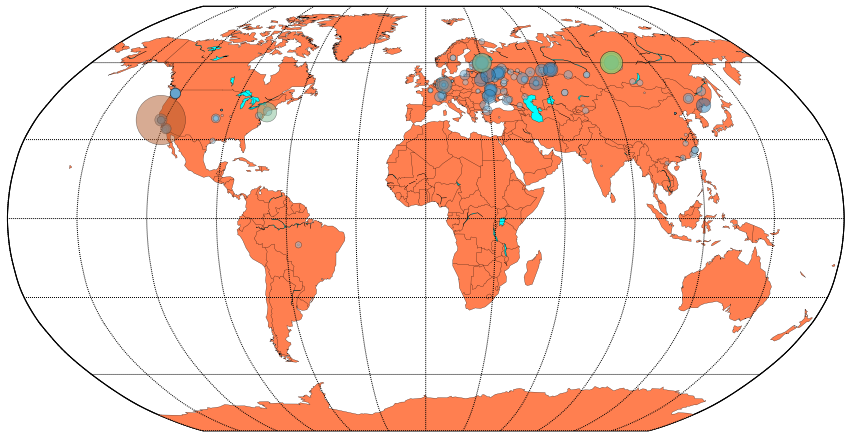

In [49]:
plt.figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary(fill_color='white')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,s=reg['Number']*3,c=reg['Number']/5,marker='o',zorder=4, cmap=cm.Paired,alpha=0.5)

Have closer look at Europe:

In [50]:
m = Basemap(projection='cyl',llcrnrlat=35,urcrnrlat=72,\
            llcrnrlon=-10,urcrnrlon=50,resolution='l')
x, y = m(reg['longitude'],reg['latitude'])

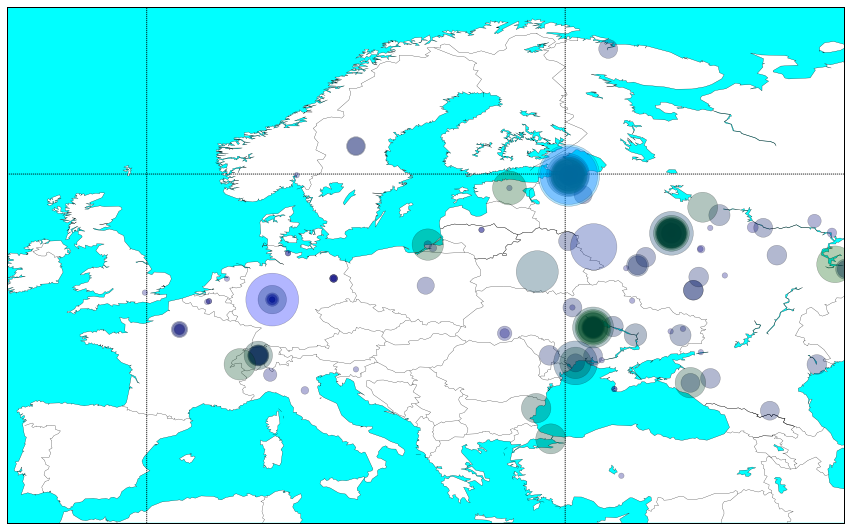

In [52]:
plt.figure(figsize=(15,15))
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)
m.fillcontinents(color='white',lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
m.drawmeridians(np.arange(0,360,30))
m.drawparallels(np.arange(-90,90,30))
m.scatter(x,y,s=reg['Number']*30,c=reg['Number'],marker='o',zorder=4, cmap=cm.gist_ncar ,alpha=0.3)


## Convert notebook to html

System commands can be accesed by !

In [53]:
!ls

Apache_log.ipynb      IPython basics.ipynb  README.md             cptls.txt             splitApplyCombine.png
GeoLiteCity.dat       Pandas basics.ipynb   access_log_for_pandas full_noinput.tpl


Convert complete notebook to html

In [54]:
!ipython nbconvert --to=html Apache_log.ipynb

[NbConvertApp] Converting notebook Apache_log.ipynb to html
[NbConvertApp] Writing 981827 bytes to Apache_log.html


Convert notebook without code cells

In [55]:
!more full_noinput.tpl

={%- extends 'full.tpl' -%}

{% block input_group -%}
{% endblock input_group %}

>

In [56]:
!ipython nbconvert --to=html --template=full_noinput.tpl Apache_log.ipynb

[NbConvertApp] Converting notebook Apache_log.ipynb to html
[NbConvertApp] Writing 919624 bytes to Apache_log.html


### Catching spammers (request methods)

Spammers are a huge problem, and it would be nice to filter them out. My website has very low user activity, and if somebody tries to POST something more than couple of times it's already suspicious. First we have to get information about what request method is being used for the requests. For this we have to analyse the *Request* column, which contain strings with requests. Request methods are always located in the beginning of the request string, so it's trivial to get it:

In [57]:
def gmet(x):
    x = x.split()
    return x[0]

We apply this little function to the *Request* column and create new *Method* column:

In [58]:
df['Method'] = df.Request.apply(gmet)

In [59]:
df.head()

,Status,Size,IP,Request,Method
Time,,,,,
2013-03-16 08:00:25,200,0.024916,109.165.31.156,GET /index.php?option=com_content&task=section...,GET
2013-03-16 08:00:25,200,0.010044,109.165.31.156,GET /templates/ja_procyon/css/template_css.css...,GET
2013-03-16 08:00:25,200,0.001767,109.165.31.156,GET /templates/ja_procyon/switcher.js HTTP/1.0,GET
2013-03-16 08:00:25,200,0.035432,109.165.31.156,GET /includes/js/overlib_mini.js HTTP/1.0,GET
2013-03-16 08:00:25,200,0.003794,109.165.31.156,GET /modules/ja_transmenu/transmenuh.css HTTP/1.0,GET


Group by *Method* and *IP*:

In [60]:
met = df.groupby(['Method', 'IP']).size()

In [61]:
met.head

<bound method Series.head of Method  IP             
GET     100.44.124.8       26
        108.171.252.242    23
        109.165.31.156     12
        109.171.109.164     4
        109.191.82.110     14
        109.200.149.88     56
        109.205.252.77     32
        109.225.55.49      13
        109.226.101.186    45
        109.230.128.168     9
        109.230.128.169    13
        109.230.132.244     2
        109.87.146.37       4
        109.87.148.141     13
        111.73.45.49       10
        112.101.64.150     33
        112.101.64.28      11
        112.78.139.130      1
        116.25.249.140      1
        117.199.193.19      1
        117.26.200.81       3
        117.27.175.158      1
        119.147.6.60        1
        120.85.235.128     10
        121.205.213.80     11
        122.201.18.26       1
        123.30.175.30       6
        128.69.187.215      2
        128.70.195.174      4
        128.70.235.42      12
                           ..
POST    176.31.40

Create *POST* time series (we have to have a copy of the time series to sort the data):

In [62]:
post = met['POST'].copy()
post.sort()

Plot the top 10 IPs that use POST method:

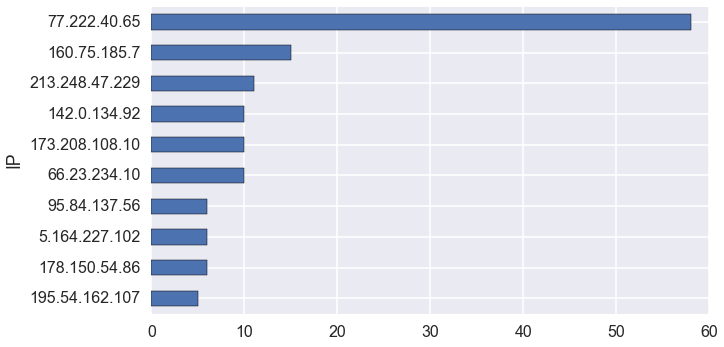

In [63]:
post[-10:].plot(kind='barh')

In [64]:
post[-5:]

IP
173.208.108.10    10
142.0.134.92      10
213.248.47.229    11
160.75.185.7      15
77.222.40.65      58
dtype: int64

What is the winner doing?

In [65]:
df[df.IP =='77.222.40.65'][0:5]

,Status,Size,IP,Request,Method
Time,,,,,
2013-03-16 08:28:43,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136340...,POST
2013-03-16 08:45:08,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136340...,POST
2013-03-16 09:19:52,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST
2013-03-16 09:36:26,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST
2013-03-16 09:40:22,403,0.001054,77.222.40.65,POST /podcast/wp-cron.php?doing_wp_cron=136341...,POST


Making some Wordpress cron requests... This IP looks familiar... Oh, it's actually the IP of my website - this is my Wordpress doing something. Have to investigate later if I can disable this thing (anyway it's not working, getting 403 error) :) 

Number two:

In [66]:
df[df.IP =='160.75.185.7'][0:10]

,Status,Size,IP,Request,Method
Time,,,,,
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST
2013-03-16 17:27:12,200,0.002224,160.75.185.7,GET /administrator/index.php HTTP/1.0,GET
2013-03-16 17:27:12,200,0.002224,160.75.185.7,POST /administrator/index.php HTTP/1.0,POST


This is suspicious; looks like it tries to get to the website's admin area - candidate for blocking.

Number three:

In [67]:
df[df.IP =='213.248.47.229'][0:10]

,Status,Size,IP,Request,Method
Time,,,,,
2013-03-16 11:00:34,200,0.012539,213.248.47.229,GET /forum/ucp.php?mode=register&sid=8203c4843...,GET
2013-03-16 11:00:34,200,0.026559,213.248.47.229,GET /forum/index.php HTTP/1.0,GET
2013-03-16 11:00:34,200,0.012011,213.248.47.229,GET /forum/ucp.php?mode=register&sid=c78851b8f...,GET
2013-03-16 11:00:39,200,0.016414,213.248.47.229,POST /forum/ucp.php?mode=register&sid=12986e06...,POST
2013-03-16 11:00:39,200,0.016414,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:44,200,0.015024,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:45,200,0.015028,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:49,200,0.015024,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST
2013-03-16 11:00:50,200,0.015028,213.248.47.229,POST /forum/ucp.php?mode=register HTTP/1.0,POST


This one tries to register on the forum every 5 second or so - clearly forum spammer. Block.